A simple example demonstrating the benefit of using GP over sample mean.

In [20]:
import matplotlib.pyplot as plt
import torch
from contextual_rs.models.contextual_independent_model import ContextualIndependentModel
from contextual_rs.experiment_utils import fit_modellist
from torch import Tensor

n_evals = 10
std_dev = 2
alpha=0.0
figsize=(12, 4)
arm_diff = 0.5
capsize = 10
torch.manual_seed(20)

In [21]:
def base_func(X: Tensor) -> Tensor:
    # return torch.sin((X[..., 0] * arm_diff + X[..., 1]) * 10)
    return (X[..., 1] + 1).pow(2) + X[..., 0] * arm_diff

In [22]:
arms = torch.tensor([[0.], [1.]])
contexts = torch.linspace(0, 1, 10).view(-1, 1)
arm_contexts = torch.cat(
    [
        arms.unsqueeze(-2).repeat(1, 10, 1), contexts.repeat(2, 1, 1)
    ], dim=-1
)
true_evals = base_func(arm_contexts)

In [23]:
noisy_evals = true_evals.repeat(n_evals, 1, 1)
noisy_evals = noisy_evals + torch.randn_like(noisy_evals) * std_dev

In [24]:
X = arm_contexts.view(-1, 2).repeat(n_evals, 1)
gp = fit_modellist(
    X=X,
    Y=noisy_evals.view(-1, 1),
    num_arms=2,
)

X_idcs = X.clone()
X_idcs[:, 1] = X_idcs[:, 1] * 9
X_idcs = X_idcs.round()

indep_model = ContextualIndependentModel(
    train_X=X_idcs,
    train_Y=noisy_evals.view(-1),
)

In [25]:
post_gp = gp.posterior(contexts)
post_indep = indep_model.posterior(X_idcs[:20])

In [26]:
with torch.no_grad():
    gp_mean = post_gp.mean
    gp_err = 2 * post_gp.variance.sqrt()
    indep_mean = post_indep.mean.view(2, 10)
    indep_err = 2 * post_indep.variance.view(2, 10).sqrt()

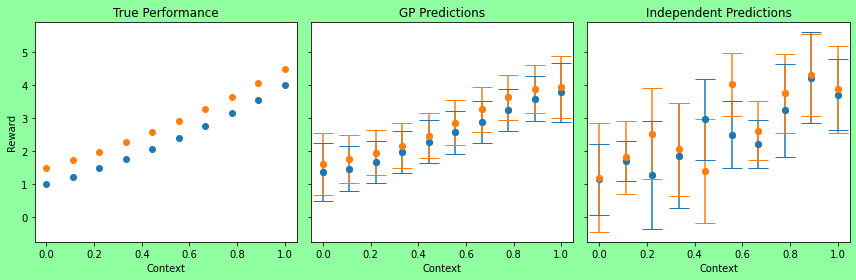

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex="all", sharey="all", figsize=figsize, squeeze=False)

axes[0, 0].scatter(contexts.view(-1), true_evals[0])
axes[0, 0].scatter(contexts.view(-1), true_evals[1])
axes[0, 0].plot(contexts.view(-1), true_evals[0], alpha=alpha)
axes[0, 0].plot(contexts.view(-1), true_evals[1], alpha=alpha)

axes[0, 1].scatter(contexts.view(-1), gp_mean[:, 0])
axes[0, 1].errorbar(contexts.view(-1), gp_mean[:, 0], yerr=gp_err[:, 0], fmt="o", capsize=capsize)
axes[0, 1].scatter(contexts.view(-1), gp_mean[:, 1])
axes[0, 1].errorbar(contexts.view(-1), gp_mean[:, 1], yerr=gp_err[:, 1], fmt="o", capsize=capsize)

axes[0, 1].plot(contexts.view(-1), gp_mean[:, 0], alpha=alpha)
axes[0, 1].plot(contexts.view(-1), gp_mean[:, 1], alpha=alpha)

axes[0, 2].scatter(contexts.view(-1), indep_mean[0])
axes[0, 2].errorbar(contexts.view(-1), indep_mean[0], yerr=indep_err[0], fmt="o", capsize=capsize)
axes[0, 2].scatter(contexts.view(-1), indep_mean[1])
axes[0, 2].errorbar(contexts.view(-1), indep_mean[1], yerr=indep_err[1], fmt="o", capsize=capsize)

axes[0, 2].plot(contexts.view(-1), indep_mean[0], alpha=alpha)
axes[0, 2].plot(contexts.view(-1), indep_mean[1], alpha=alpha)


axes[0, 0].set_title("True Performance")
axes[0, 1].set_title("GP Predictions")
axes[0, 2].set_title("Independent Predictions")

for i in range(3):
    axes[0, i].set_xlabel("Context")
axes[0, 0].set_ylabel("Reward")

fig.tight_layout()
plt.savefig("plots/example.pdf", dpi=300)
fig.patch.set_facecolor('xkcd:mint green')
plt.show()

xlim = axes[0, 0].get_xlim()
ylim = axes[0, 0].get_ylim()

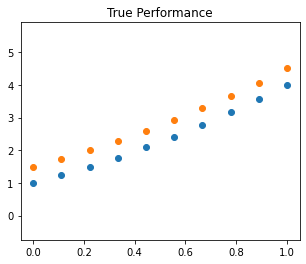

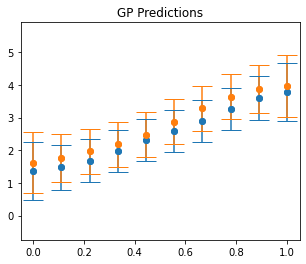

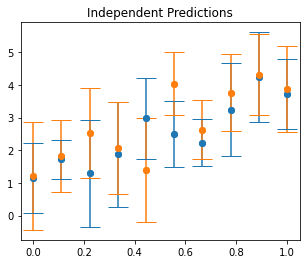

In [28]:
figsize = (5, 4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("True Performance")

ax.scatter(contexts.view(-1), true_evals[0])
ax.scatter(contexts.view(-1), true_evals[1])
ax.plot(contexts.view(-1), true_evals[0], alpha=alpha)
ax.plot(contexts.view(-1), true_evals[1], alpha=alpha)

plt.savefig("plots/example_true.pdf", dpi=300)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("GP Predictions")

ax.scatter(contexts.view(-1), gp_mean[:, 0])
ax.errorbar(contexts.view(-1), gp_mean[:, 0], yerr=gp_err[:, 0], fmt="o", capsize=capsize)
ax.scatter(contexts.view(-1), gp_mean[:, 1])
ax.errorbar(contexts.view(-1), gp_mean[:, 1], yerr=gp_err[:, 1], fmt="o", capsize=capsize)

ax.plot(contexts.view(-1), gp_mean[:, 0], alpha=alpha)
ax.plot(contexts.view(-1), gp_mean[:, 1], alpha=alpha)

plt.savefig("plots/example_gp.pdf", dpi=300)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Independent Predictions")

ax.scatter(contexts.view(-1), indep_mean[0])
ax.errorbar(contexts.view(-1), indep_mean[0], yerr=indep_err[0], fmt="o", capsize=capsize)
ax.scatter(contexts.view(-1), indep_mean[1])
ax.errorbar(contexts.view(-1), indep_mean[1], yerr=indep_err[1], fmt="o", capsize=capsize)

ax.plot(contexts.view(-1), indep_mean[0], alpha=alpha)
ax.plot(contexts.view(-1), indep_mean[1], alpha=alpha)

plt.savefig("plots/example_indep.pdf", dpi=300)